In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import torch.nn as nn
import torch 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt 

DEVICE = "cuda:1"
IS_P2 = True 

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])


## Step1: Load checkpoint and evaluate to get extracted features

In [33]:
# Hints:
# Set features_extractor to eval mode
# Start evaluation and collect features and labels

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)

# Load model
feature_extractor = FeatureExtractor().to(DEVICE)
feature_extractor.load_state_dict(torch.load('extractor_model.bin'))
# 
label_predictor = LabelPredictor().to(DEVICE)
label_predictor.load_state_dict(torch.load('predictor_model.bin'))
# 
# Inference
features = []
y = []
label_predictor.eval()
feature_extractor.eval()
for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

    source_data = source_data.to(DEVICE)
    target_data = target_data.to(DEVICE)
    
    feature = feature_extractor(source_data)
    feature_target = feature_extractor(target_data)
    # 
    features.append(feature.cpu().detach().numpy())
    if IS_P2:
        features.append(feature_target.cpu().detach().numpy())
    # 
    if not IS_P2:
        y.append(source_label)
    else:
        y.append(np.concatenate([np.zeros(32), np.ones(32)]))
features = np.concatenate(features)
y        = np.concatenate(y)

print(features.shape) # (5000, 512)
print(y.shape) # (5000,)


(10024, 512)
(10048,)


## Step2: Apply t-SNE and normalize

In [34]:
# process extracted features with t-SNE
X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(features)

# Normalization the processed features 
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10024 samples in 0.005s...


/home/lab530/anaconda3/envs/KenYuML/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10024 samples in 1.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10024
[t-SNE] Computed conditional probabilities for sample 2000 / 10024
[t-SNE] Computed conditional probabilities for sample 3000 / 10024
[t-SNE] Computed conditional probabilities for sample 4000 / 10024
[t-SNE] Computed conditional probabilities for sample 5000 / 10024
[t-SNE] Computed conditional probabilities for sample 6000 / 10024
[t-SNE] Computed conditional probabilities for sample 7000 / 10024
[t-SNE] Computed conditional probabilities for sample 8000 / 10024
[t-SNE] Computed conditional probabilities for sample 9000 / 10024
[t-SNE] Computed conditional probabilities for sample 10000 / 10024
[t-SNE] Computed conditional probabilities for sample 10024 / 10024
[t-SNE] Mean sigma: 2.513165
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.137634
[t-SNE] KL divergence after 1000 iterations: 1.832716


## Step3: Visualization with matplotlib

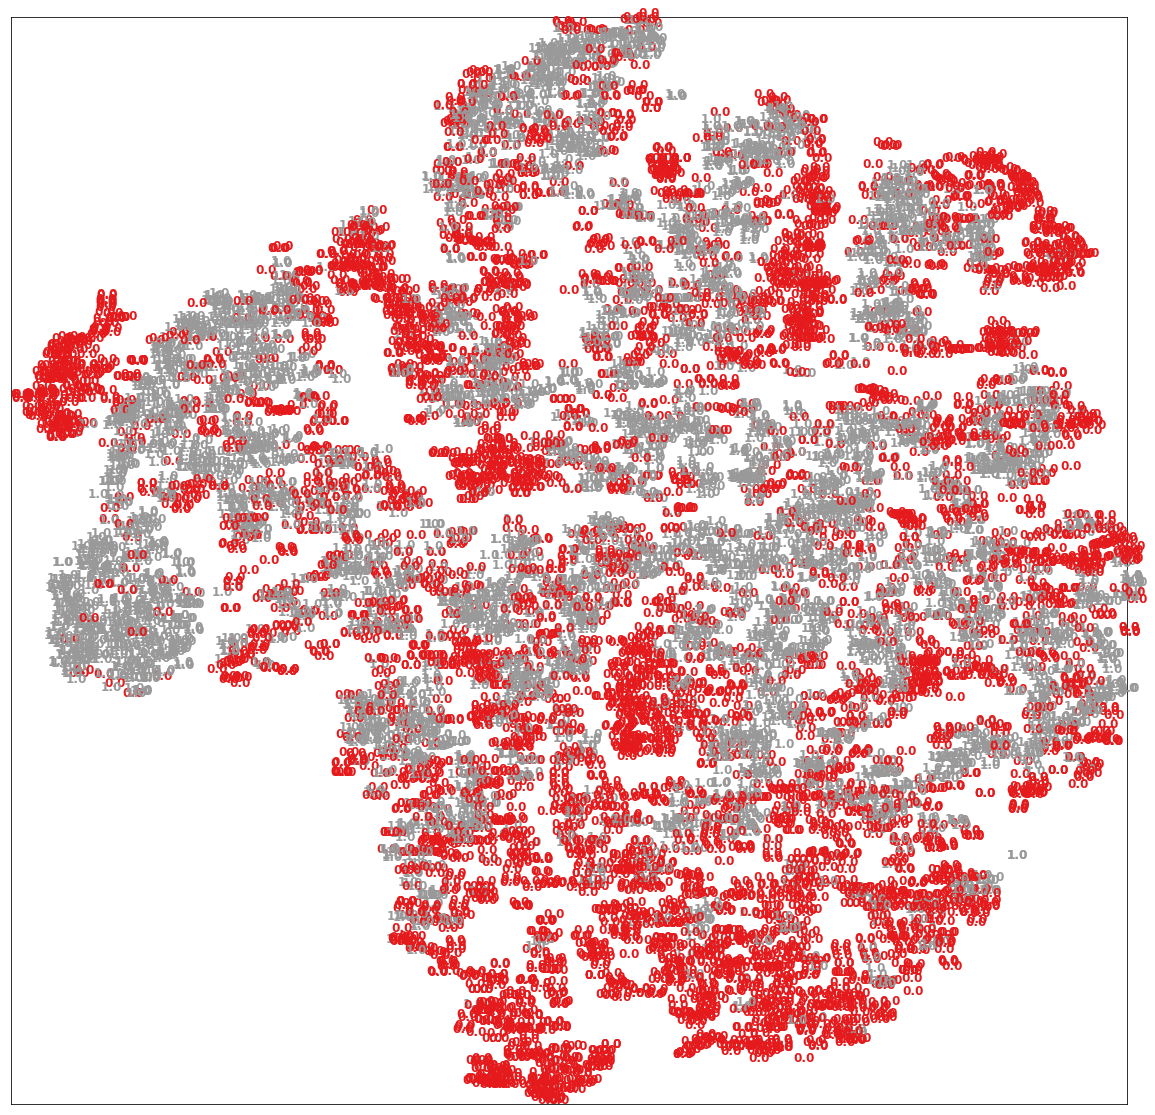

In [35]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

#Data Visualization
plt.figure(figsize=(20, 20))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 12})
plt.xticks([])
plt.yticks([])
plt.savefig("tsne.jpg")
plt.show()
